<a href="https://colab.research.google.com/github/Harris-giki/Classification_Transformer_Models/blob/main/SwinTransformer_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#import os
#os.listdir('/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/5, Train Loss: 61.4643, Train Accuracy: 60.00%, Val Accuracy: 68.11%
Epoch 2/5, Train Loss: 48.1271, Train Accuracy: 71.41%, Val Accuracy: 70.78%
Epoch 3/5, Train Loss: 35.4850, Train Accuracy: 81.43%, Val Accuracy: 78.80%
Epoch 4/5, Train Loss: 24.4700, Train Accuracy: 88.91%, Val Accuracy: 79.97%
Epoch 5/5, Train Loss: 19.0180, Train Accuracy: 91.91%, Val Accuracy: 83.14%

Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       320
           1       0.77      0.95      0.85       280

    accuracy                           0.84       600
   macro avg       0.86      0.85      0.84       600
weighted avg       0.86      0.84      0.84       600



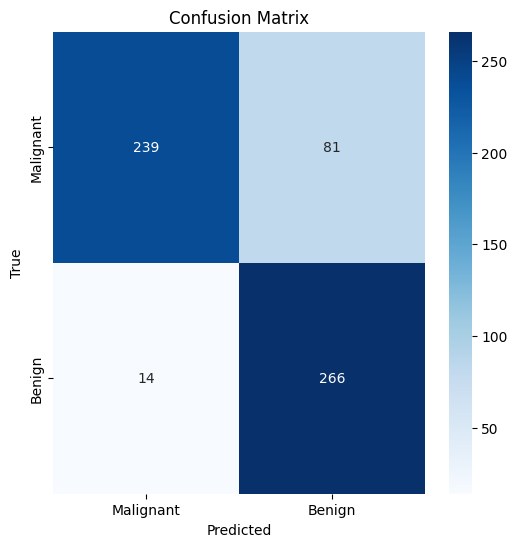

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class TumorDataset(Dataset):
    def __init__(self, malignant_dir, benign_dir, transform=None):
        self.data = []
        self.labels = []

        for img_name in os.listdir(malignant_dir):
            img_path = os.path.join(malignant_dir, img_name)
            self.data.append(img_path)
            self.labels.append(0)

        for img_name in os.listdir(benign_dir):
            img_path = os.path.join(benign_dir, img_name)
            self.data.append(img_path)
            self.labels.append(1)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

class SwinBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        # Using standard LayerNorm for channel dimension
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        # Attention layer
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout)

        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Reshape and permute for LayerNorm
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C]

        # First norm and attention
        shortcut = x
        x = self.norm1(x)  # Normalize over channel dimension

        # Reshape for attention
        x = x.reshape(B, H * W, C)  # [B, H*W, C]
        x = x.permute(1, 0, 2)  # [H*W, B, C]

        # Self-attention
        attn_out, _ = self.attn(x, x, x)

        # Reshape back
        attn_out = attn_out.permute(1, 0, 2)  # [B, H*W, C]
        attn_out = attn_out.reshape(B, H, W, C)  # [B, H, W, C]

        # First residual connection
        x = shortcut + attn_out

        # Second norm and MLP
        shortcut = x
        x = self.norm2(x)

        # Reshape for MLP
        x = x.reshape(B * H * W, C)
        x = self.mlp(x)
        x = x.reshape(B, H, W, C)

        # Second residual connection
        x = shortcut + x

        # Restore original dimension order
        x = x.permute(0, 3, 1, 2)  # [B, C, H, W]

        return x

class SwinTransformerV2(nn.Module):
    def __init__(self, input_resolution=(224, 224), patch_size=4, num_classes=2, embed_dim=96):
        super().__init__()
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.embed_dim = embed_dim

        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.positional_embedding = nn.Parameter(torch.zeros(1, embed_dim, input_resolution[0] // patch_size, input_resolution[1] // patch_size))

        # Modified input resolution for stages
        stage1_resolution = (input_resolution[0] // patch_size, input_resolution[1] // patch_size)
        stage2_resolution = (stage1_resolution[0] // 2, stage1_resolution[1] // 2)

        self.stage1 = SwinBlock(embed_dim, stage1_resolution, num_heads=3)
        self.downsample = nn.Conv2d(embed_dim, embed_dim * 2, kernel_size=2, stride=2)
        self.stage2 = SwinBlock(embed_dim * 2, stage2_resolution, num_heads=6)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(embed_dim * 2, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.positional_embedding
        x = self.stage1(x)
        x = self.downsample(x)
        x = self.stage2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Paths to your directories
MALIGNANT_DIR = "/content/Malignant"
BENIGN_DIR = "/content/Benign"

# Dataset and DataLoader
dataset = TumorDataset(MALIGNANT_DIR, BENIGN_DIR, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinTransformerV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_val_accuracy = 0
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_swin_v2_model.pth')

# Evaluate on the test set and calculate additional metrics
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute metrics
    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_predictions))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Train and Evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# After training, evaluate the model on the test set
evaluate_model(model, test_loader)
